# DEtection TRansfomer (DETR)


# 论文介绍

[Paper: End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872)

DETR 也是由 Meta 的 FAIR 团队在 2020 年发表在 ECCV 上的文章，DETR 是第一个基于 Transformer Encoder-Decoder 架构的检测模型，而且它是一个真正意义上的端到端的模型，它不需要显示的人工设计 Anchor，也不需要对模型输出的所有的 Bbox 进行 NMS（非极大值抑制）。

以下是论文的摘要：

> 我们提出了一种新的方法，将目标检测视为 directly set prediction problem (直接集合预测问题) 。我们的方法简化了检测流程，有效地消除了许多手动设计的组件，如非极大值抑制过程或锚点生成，这些组件明确地编码了我们关于任务的先验知识。新框架的主要成分被称为 DEtection TRansformer 或 DETR，包括一个基于集合的全局损失，通过二分图匹配强制进行唯一预测，以及一个编码器-解码器架构。给定一组固定的学习对象查询，DETR 通过推理对象之间的关系和全局图像上下文，直接并行输出最终的预测集合。与许多其他现代检测器不同，新的模型概念简单，无需专用库。DETR 在具有挑战性的 COCO 目标检测数据集上展示了与成熟的、高度优化的 Faster RCNN 基线相当的准确性和运行时性能。此外，DETR 可以轻松推广，以统一的方式生成全景分割。我们表明，它在性能上显著优于竞争性基线。

总结起来，DETR 的主要贡献有两点：

1. 将 Transformer 引入到目标检测领域，那个时候（2020 年 5 月）还没有 ViT（2020 年 10 月）。
2. 为物体检测任务引入了一种新的解决方案范式，将其视为一个集合预测问题。通过引入一个 “object query" 的解码器输入，摆脱了锚点的问题。

## 其他参考教程

* 官方 Github 代码仓库：https://github.com/facebookresearch/detr
* https://medium.com/@rafaeltol/understanding-and-coding-detr-detection-transfomer-80e4c206fbc8

# 导入相关的包与模块

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

# 构建 COCO 检测数据集并可视化

## 自定义数据集与数据预处理


COCO 数据集中每个目标的标注信息都存储在一个字典中，里面包括了 `bbox`, `segmentation`, `image_id`, `category_id`等信息。在目标检测中，我们主要是从中提取到矩形框的坐标以及对应的目标的类别信息。

`preprocess_target` 函数对 `annotations`进行处理，主要完成了以下几个重要的功能：

1. 过滤掉一些坐标值不合法的目标框
2. 将 `bbox` 的表示从 `[x, y, w, h]` 转换为 `[cx, cy, w, h]`，而且把数值归一化到了`[0,1]`之间。
3. 从 annotations 中提取目标对应的 `cls_id` 以及对应的 `bbox`

In [2]:
def preprocess_target(annotations, image_width, image_height):
    """
    Processes annotations to filter, normalize, and format bounding boxes and their corresponding classes.

    Parameters:
    - annotations: List of dictionaries, each containing information about an object, such as bounding box ('bbox')
                   and category ('category_id').
    - image_width: Width of the image in pixels.
    - image_height: Height of the image in pixels.

    Returns:
    - classes: (n_targets,) Tensor of class IDs for each bounding box.
    - boxes: (n_targets, 4) Tensor of bounding boxes in the format [center_x, center_y, width, height], normalized to [0, 1].
    """
    # Filter out objects marked as 'crowd' (if "iscrowd" exists and is non-zero)
    annotations = [
        obj for obj in annotations if "iscrowd" not in obj or obj["iscrowd"] == 0
    ]

    # Extract bounding boxes from annotations and convert to tensor
    boxes = [obj["bbox"] for obj in annotations]
    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)

    # Convert boxes from [x, y, width, height] (xywh) to [x_min, y_min, x_max, y_max] (xyxy) format
    boxes[:, 2:] += boxes[:, :2]  # x_max = x_min + width; y_max = y_min + height

    # Clamp box coordinates to ensure they lie within image bounds
    boxes[:, 0::2].clamp_(
        min=0, max=image_width
    )  # Clamp x coordinates to [0, image_width]
    boxes[:, 1::2].clamp_(
        min=0, max=image_height
    )  # Clamp y coordinates to [0, image_height]

    # Filter out invalid boxes where x_max <= x_min or y_max <= y_min
    valid_boxes = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[valid_boxes]

    # Extract class IDs for valid boxes
    classes = [obj["category_id"] for obj in annotations]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[valid_boxes]

    # Normalize box coordinates to [0, 1] by dividing by image dimensions
    boxes[:, 0::2] /= image_width  # Normalize x coordinates
    boxes[:, 1::2] /= image_height  # Normalize y coordinates
    boxes.clamp_(min=0, max=1)  # Ensure normalized coordinates are in [0, 1] range

    # Convert boxes from [x_min, y_min, x_max, y_max] (xyxy) to [center_x, center_y, width, height] (cxcywh) format
    boxes = ops.box_convert(boxes, in_fmt="xyxy", out_fmt="cxcywh")

    return classes, boxes

`MyCoCoDetection` 数据集在遍历时，每次返回的是数据集中的一张图像，以及这张图像中所有目标的位置与类别信息。它是在 `datasets.CocoDetection` 数据集的基础上做了包装，主要是自定义 target 部分的预处理。在 target 的预处理函数里，除了 annotation 之外，还需要获取对应图片的高与宽用于对 `bbox` 进行归一化。

In [3]:
class MyCoCoDetection(datasets.CocoDetection):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge = 480

        self.T = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                T.Resize((self.edge, self.edge), antialias=True),  # antialias 抗锯齿
            ]
        )

        self.T_target = preprocess_target

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # w, h 是图像的原始大小，而不是 resize 后的大小，避免 bbox 归一化的范围不对
        w, h = img.size

        input_ = self.T(img)
        classes, boxes = self.T_target(target, w, h)

        return input_, (classes, boxes)

    @staticmethod
    def collate_fn(inputs):
        input_ = torch.stack([i[0] for i in inputs])
        classes = tuple([i[1][0] for i in inputs])
        boxes = tuple([i[1][1] for i in inputs])

        return input_, (classes, boxes)

In [4]:
train_ds = MyCoCoDetection(
    root="../../data/tiny_coco_dataset/tiny_coco/train2017/",
    annFile="../../data/tiny_coco_dataset/tiny_coco/annotations/instances_train2017.json",
)

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=False, collate_fn=MyCoCoDetection.collate_fn
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## COCO 标注框的可视化

In [5]:
COCO_CLASSES = [
    "N/A",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
    "empty",
]

# Colors for visualization
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]
COLORS *= 100


def plot_image_with_boxes(image, boxes, probs=None, ax=None):
    """
    Plots an image with bounding boxes and optional class labels or probabilities.

    Parameters:
    - image: The image to display.
    - boxes: A tensor or list of bounding boxes, each in the format [xmin, ymin, xmax, ymax].
    - probs: Optional; probabilities or class predictions for each bounding box. If provided,
             should be either a 1D array of class indices or a 2D array of probabilities.
    - ax: Optional; Matplotlib axis to plot on. If None, a new axis will be created.

    Returns:
    - None; displays the image with bounding boxes and class labels (if probs is provided).
    """

    # Create a new axis if one is not provided
    if ax is None:
        plt.imshow(image)
        ax = plt.gca()

    # Plot each bounding box
    for i, box in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = box

        # Draw the rectangle for the bounding box
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,  # No fill color
            color=COLORS[i],
            linewidth=2,
        )
        ax.add_patch(rect)

        # Prepare the label text if probabilities are provided
        if probs is not None:
            if probs.ndim == 1:  # If 1D, treat as class labels
                class_index = probs[i].item()
                text = f"{COCO_CLASSES[class_index]}"
            else:  # If 2D, use the probability for the most likely class
                class_index = probs[i].argmax().item()
                text = f"{COCO_CLASSES[class_index]}: {probs[i, class_index]:0.2f}"
        else:
            text = ""  # No text if probs are not provided

        # Annotate the bounding box with the label text
        ax.text(
            xmin,
            ymin,
            text,
            fontsize=7,
            bbox=dict(
                facecolor="yellow", alpha=0.5
            ),  # Text background with transparency
        )

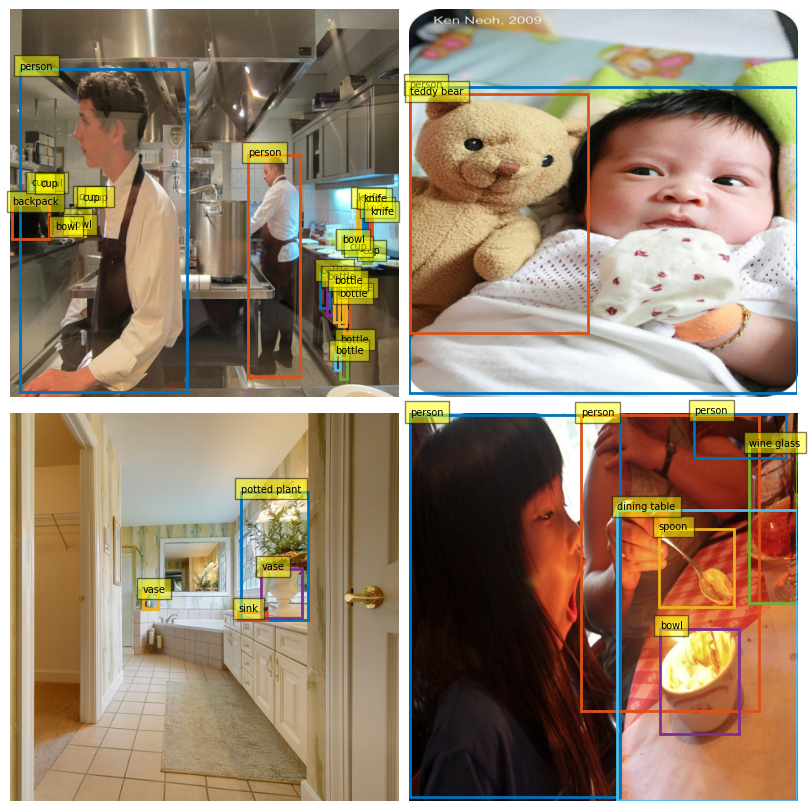

In [6]:
revert_normalization = T.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
)


im_tensors, (classes, boxes) = next(iter(train_loader))
images = revert_normalization(im_tensors)

fig = plt.figure(figsize=(8, 8), constrained_layout=True)

for ix in range(4):
    target_cls = classes[ix]
    target_bbox = boxes[ix]
    target_bbox = ops.box_convert(target_bbox * 480, in_fmt="cxcywh", out_fmt="xyxy")
    im = images[ix].permute(1, 2, 0).cpu().clip(0, 1)

    ax = fig.add_subplot(2, 2, ix + 1)
    ax.imshow(im)
    plot_image_with_boxes(im, boxes=target_bbox, probs=target_cls, ax=ax)
    ax.set_axis_off()

# DETR 模型架构

![alt text](../images/detr_model_arch.png)

从上面的架构图中，我们可以看出，DETR 模型主要由以下几部分组成：

1. CNN Backbone：负责抽取图像的特征，将图像从原始分辨率压缩为一个尺寸较小的特征图。
2. Transformer encoder：将 CNN 出来的 feature map 加入位置编码后，在多层的 SelfAttetion 和 FFN 中进行空间与特征维度上的深度融合，抽取更高层的特征。
3. Transformer decoder: 除了接收 encoder 出来的高层语义特征作为 memory 之外，还输入了一个可学习的 object queries，object queries 与 memory 进行交叉注意力，感知到不同位置上的不同目标。
4. FFN Heads: 每一个 object queries 在 decoder 中都对应一个输出，然后会接着两个 FFN Head （尽管上图中只画了一个出来），一个用于回归 4 个 bbox 的坐标，一个用于进行类别分类。

## CNN Backbone

图像骨干提取图像特征并缩小原始图像尺寸，将图像块转换为嵌入表示。当使用标准的 ResNet-50 时，尺寸缩小了 32 倍，这相当于在原始 ViT 中使用 32 像素的块大小。考虑一个输入图像的尺寸为（480, 480, 3），这相当于一个维度为（1, 3, 480, 480）的输入张量。经过 ResNet 主干网络处理后，输入张量变为一个尺寸为（1, 2048, 15, 15）的粗糙特征图。空间信息被压缩，但深度维度被扩大。

输出的 feature map 的 channel 太大，导致 Transformer 编码器的计算负载很重。通过应用随后的 1x1 卷积层，可以将通道维度从 2048 降低到 256，从而减轻这种负载。

在这个阶段，数据张量从 (B, 3, H, W) 变为 (B, C, T', T')。嵌入层的通道数（C = 256）在整个 Transformer 过程中保持不变，这个值被称为“模型宽度”。

In [7]:
import timm


backbone = timm.create_model("resnet50", pretrained=True)

d_model = 256
backbone_feature_chns = backbone.feature_info[-1]["num_chs"]
conv1x1 = nn.Conv2d(backbone_feature_chns, d_model, 1)

x = torch.randn(1, 3, 480, 480)
feature_map = backbone.forward_features(x)
feature_map = conv1x1(feature_map)
print(feature_map.shape)

torch.Size([1, 256, 15, 15])


## 添加位置编码

在将嵌入信息输入编码器之前，需要进行以下操作：1）将图像嵌入重排为 1 维序列长度，2）添加位置编码信息。

In [8]:
embeddings = rearrange(feature_map, "b c h w -> b (h w) c")
print(embeddings.shape)

torch.Size([1, 225, 256])


一些方法可以将位置编码（PE）添加到嵌入中，例如将 x 和 y 的块坐标建模为正弦函数，甚至在学习过程中一并学习它。这两种方法在 DETR 工作中都尝试过，下面我们使用的是添加可学习的位置编码。

In [9]:
position_embeddings = nn.Parameter(torch.rand(1, embeddings.shape[1], d_model))
embeddings += position_embeddings

## Transformer Encoder

在完成必要的预步骤后，我们实例化了编码器本身。在整个 Transformer 传递过程中，包括解码器，张量的维度（B, T, C），在我们的例子中为（1, 255, 256），保持不变。

In [10]:
nheads = 8

encoder_layer = nn.TransformerEncoderLayer(
    d_model, nheads, dim_feedforward=4 * d_model, batch_first=True
)
n_layers = 6

transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)

encoder_out = transformer_encoder(embeddings)
print(encoder_out.shape)

torch.Size([1, 225, 256])


## Transformer Decoder

DETR 引入了一个核心概念，即 Object Queries。这些查询代表了对框预测的请求；因此，Q 个对象查询返回 Q 个框预测。从实际角度来看，这些查询是简单的 PE，为解码器提供输入。

一个注意事项：当同时运行 Batch size 个 实例时，Q 信息会复制 B 的长度；编码器的 PE 也会出现相同的情况。查询张量的形状为（B，Q，C）。

In [11]:
n_queries = 100

queries = nn.Parameter(torch.rand(1, n_queries, d_model))

In [12]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model, nheads, dim_feedforward=4 * d_model, batch_first=True
)
transformer_decoder = nn.TransformerDecoder(decoder_layer, n_layers)

decoder_out = transformer_decoder(queries, encoder_out)
print(decoder_out.shape)

torch.Size([1, 100, 256])


## FFN Heads

最后，在架构的最顶层，两个全连接神经网络（FFN）接收解码器的输出作为输入。其中一个 FFN 预测框类别，另一个 FFN 预测框坐标。在维度上，解码器的输出形状为（B，T，Q），由负责类别预测的 FFN 转换为（B，Q，92），由负责坐标预测的 FFN 转换为（B，Q，4）。

In [13]:
n_classes = len(COCO_CLASSES)

class_classifer = nn.Linear(d_model, n_classes)
bbox_regressor = nn.Linear(d_model, 4)

classes_pred = class_classifer(decoder_out)
bboxes_pred = bbox_regressor(decoder_out)

print(classes_pred.shape, bboxes_pred.shape)

torch.Size([1, 100, 92]) torch.Size([1, 100, 4])


## 把所有模块拼在一起

In [14]:
def get_hook(outs, name):
    def hook(self, x, out):
        outs[name] = out

    return hook


class DETR(nn.Module):
    def __init__(
        self,
        d_model=256,
        nclasses=92,
        nheads=8,
        nlayers=6,
        n_queires=100,
        max_tokens=512,
        backbone="resnet50",
    ):
        super().__init__()

        self.backbone = timm.create_model(backbone, pretrained=True)
        feature_chns = self.backbone.feature_info[-1]["num_chs"]
        self.conv1x1 = nn.Conv2d(feature_chns, d_model, 1)

        self.encoder_pe = nn.Parameter(torch.randn(1, max_tokens, d_model))
        self.queires = nn.Parameter(torch.randn(1, n_queires, d_model))

        self.transfomer = nn.Transformer(
            d_model,
            nhead=nheads,
            num_decoder_layers=nlayers,
            num_encoder_layers=nlayers,
            dim_feedforward=4 * d_model,
            batch_first=True,
        )

        self.class_classifer = nn.Linear(d_model, nclasses)
        self.bbox_regressor = nn.Linear(d_model, 4)

        self.decoder_outs = {}

        for i, layer in enumerate(self.transfomer.decoder.layers):
            name = f"layer_{i}"
            layer.register_forward_hook(get_hook(self.decoder_outs, name))

    def forward(self, x):
        feature_map = self.conv1x1(self.backbone.forward_features(x))
        embeddings = rearrange(feature_map, "b c h w -> b (h w) c")
        num_tokens = embeddings.shape[1]
        embeddings += self.encoder_pe[:, :num_tokens]

        _ = self.transfomer(embeddings, self.queires.repeat(embeddings.shape[0], 1, 1))

        outs = {}
        for name, hidden_state in self.decoder_outs.items():
            outs[name] = {
                "cls": self.class_classifer(hidden_state),
                "bbox": self.bbox_regressor(hidden_state),
            }

        return outs

In [15]:
detr = DETR(d_model=256, nclasses=len(COCO_CLASSES))

x = torch.randn(1, 3, 480, 480)
outs = detr(x)

cls_pred, bbox_pred = outs["layer_5"].values()
print(cls_pred.shape, bbox_pred.shape)

torch.Size([1, 100, 92]) torch.Size([1, 100, 4])


# DETR 的损失函数

我们的下一步是理解 DETR 训练的特定之处。我们将分为三个部分：1）集合预测问题，2）复合损失函数，和 3）辅助损失。

## 集合预测问题

在 DETR 项目中，一种创新的方法是将检测任务视为集合预测任务。这种范式涉及在预测集合和标签集合之间进行元素匹配，目标是使匹配之间的误差总和最小化，而不是单个框的误差总和。最优匹配集合是通过一种称为匈牙利算法的二分图匹配算法来计算的。

匈牙利算法作用于一个成本（Cost）矩阵，该矩阵存储了两个集合中所有元素之间的差异。需要注意的是，并非每个元素都与其最佳对应项匹配，因为二分图算法优化的是匹配的总和。

成本矩阵的维度为（Q，len(target)），其中每个单元格（i，j）存储预测“i”与标签“j”对的相似度度量。相似度度量是广义交并比（GIoU）在框上的加权求和、框坐标（xy，xy）之间的 L1 范数以及框类别概率之间的 L1 范数的加权求和。相应的权重为 1、5 和 2。使用方法 linear_sum_assignment 应用匈牙利算法。

训练过程中一个关键点是如何处理每个 COCO 图像中不同数量的框。在 COCO 图像中，框的数量在 1 到 63 个之间变化。另一方面，DETR 假设一个固定的预测数量，即查询大小 Q 为 100。这个问题通过为所有没有对应匹配的预测分配一个额外的“空类”来解决。

In [16]:
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=MyCoCoDetection.collate_fn
)
input_, (tgt_cls, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
pred_cls, pred_bbox = outs["layer_5"].values()

pred_bbox = pred_bbox.sigmoid()

# 去除 batch 维度

pred_bbox = pred_bbox[0]  # (100, 4)
tgt_bbox = tgt_bbox[0]  # (n_objects, 4)

pred_cls = pred_cls[0]  # (100, d_model)
tgt_cls = tgt_cls[0]  # (n_objects,)

pred_probs = pred_cls.softmax(dim=-1)  # (100, d_model)

C_classes = -pred_cls[..., tgt_cls]  # (100, n_objects)
C_boxes = torch.cdist(pred_bbox, tgt_bbox, p=1)  # (100, n_objects)
C_giou = -ops.generalized_box_iou(
    ops.box_convert(pred_bbox, in_fmt="cxcywh", out_fmt="xyxy"),
    ops.box_convert(tgt_bbox, in_fmt="cxcywh", out_fmt="xyxy"),
)
C_total = 1 * C_classes + 5 * C_boxes + 2 * C_giou
C_total = C_total.cpu().detach().numpy()


# pred_ixs 是预测集合中所有能匹配上的索引，tgt_ixs 是目标集合中所有与预测集合对应的索引
pred_ixs, tgt_ixs = linear_sum_assignment(C_total)
print(f"pred_ixs.shape= {pred_ixs.shape}, tgt_ixs.shape = {tgt_ixs.shape}")

# 下面我们调整一下顺序，将pred_ixs 调整为分别与 tgt中的目标原有顺序一一匹配的索引
pred_ixs = torch.tensor(pred_ixs, dtype=torch.int64)
tgt_ixs = torch.tensor(tgt_ixs, dtype=torch.int64)
pred_ixs = pred_ixs[tgt_ixs.argsort()]

pred_ixs.shape= (26,), tgt_ixs.shape = (26,)


## 计算所有预测目标的损失

In [17]:
num_bbox = len(tgt_bbox)

loss_bbox = F.l1_loss(pred_bbox[pred_ixs], tgt_bbox, reduction="sum") / num_bbox

target_gIOU = ops.generalized_box_iou(
    ops.box_convert(pred_bbox[pred_ixs], in_fmt="cxcywh", out_fmt="xyxy"),
    ops.box_convert(tgt_bbox, in_fmt="cxcywh", out_fmt="xyxy"),
)
loss_giou = 1 - torch.diag(target_gIOU).mean()

queries_classes_label = torch.full(pred_probs.shape[:1], 91)
queries_classes_label[pred_ixs] = tgt_cls
loss_cls = F.cross_entropy(pred_cls, queries_classes_label)

loss_total = 1 * loss_cls + 5 * loss_bbox + 2 * loss_giou
print(loss_total)

tensor(14.7553, grad_fn=<AddBackward0>)


## Auxiliary Loss

现在我们已经知道了如何计算损失，为了加快收敛速度和稳定训练过程，一个重要的细节是辅助损失。在这种情况下，辅助损失仅将相同的损失函数应用于变压器解码器所有中间层的输出。为此，所有中间特征都是通过在 DETR 类片段中声明的 get_hook 函数获得的。然后，使用相同的 FFN 头部来预测每个解码器层的边界框坐标和类别。

## 组装一个完整的损失函数

In [18]:
def compute_one_sample_loss(
    pred_bbox: torch.Tensor,
    tgt_bbox: torch.Tensor,
    pred_cls: torch.Tensor,
    tgt_cls: torch.Tensor,
    empty_cls_label: int = 91,
):
    """
    计算单个样本的类别损失、边界框L1损失和广义IoU损失。

    Parameters:
        pred_bbox: 预测边界框，大小为 (n_queries, 4)。
        tgt_bbox: 目标边界框，大小为 (n_objects, 4)。
        pred_cls: 预测类别概率，大小为 (n_queries)。
        tgt_cls: 目标类别标签，大小为 (n_objects)。
        empty_cls_label: 无目标对象时的类别标签，默认为91。

    Returns:
        loss_cls: 类别交叉熵损失。
        loss_bbox: 边界框L1损失。
        loss_giou: 广义IoU损失。
    """
    n_queries = len(pred_cls)
    device = pred_cls.device

    if len(tgt_cls) == 0:
        # 说明当前图片上，没有合法的待检测目标，那么我们只计算预测框的类别损失
        queries_classes_label = torch.full((n_queries,), empty_cls_label, device=device)
        loss_cls = F.cross_entropy(pred_cls, queries_classes_label)
        loss_bbox = loss_giou = torch.tensor(0.0, device=device)
        return loss_cls, loss_bbox, loss_giou

    pred_probs = pred_cls.softmax(dim=-1)  # (n_queries, d_model)

    # 概率值越大，说明类别越匹配，则 cost 越小，所以需要取负号
    cost_cls = -pred_probs[..., tgt_cls]  # (n_queries, n_objects)

    cost_boxes = torch.cdist(pred_bbox, tgt_bbox, p=1)  # (n_queries, n_objects)

    # iou 越大，则说明两个 bbox 越匹配，则 cost 越小
    cost_giou = -ops.generalized_box_iou(
        ops.box_convert(pred_bbox, in_fmt="cxcywh", out_fmt="xyxy"),
        ops.box_convert(tgt_bbox, in_fmt="cxcywh", out_fmt="xyxy"),
    )
    cost_total = 1 * cost_cls + 5 * cost_boxes + 2 * cost_giou
    cost_total = cost_total.detach().cpu().numpy()

    # pred_ixs 是预测集合中所有能匹配上的索引，tgt_ixs 是目标集合中所有与预测集合对应的索引
    pred_ixs, tgt_ixs = linear_sum_assignment(cost_total)

    # 下面我们调整一下顺序，将pred_ixs 调整为分别与 tgt中的目标原有顺序一一匹配的索引
    pred_ixs = torch.tensor(pred_ixs, dtype=torch.int64)
    tgt_ixs = torch.tensor(tgt_ixs, dtype=torch.int64)
    pred_ixs = pred_ixs[tgt_ixs.argsort()]

    loss_bbox = F.l1_loss(pred_bbox[pred_ixs], tgt_bbox, reduction="sum") / len(
        tgt_bbox
    )

    target_giou = ops.generalized_box_iou(
        ops.box_convert(pred_bbox[pred_ixs], in_fmt="cxcywh", out_fmt="xyxy"),
        ops.box_convert(tgt_bbox, in_fmt="cxcywh", out_fmt="xyxy"),
    )
    # 只需要计算对角线上一一对应的框之间的 IOU 损失
    loss_giou = 1 - torch.diag(target_giou).mean()

    queries_classes_label = torch.full((n_queries,), 91, device=device)
    queries_classes_label[pred_ixs] = tgt_cls
    loss_cls = F.cross_entropy(pred_cls, queries_classes_label)

    return loss_cls, loss_bbox, loss_giou

# 模型训练

In [19]:
d_model = 256
n_classes = len(COCO_CLASSES)
max_tokens = 512
n_layers = 6
nheads = 8
n_queries = 100

device = torch.device("cuda")

detr = DETR(
    d_model=d_model,
    nclasses=n_classes,
    nheads=nheads,
    nlayers=n_layers,
    n_queires=n_queries,
    max_tokens=max_tokens,
)
detr = detr.to(device=device)

# 将backbone 冻住
for p in detr.backbone.parameters():
    p.requires_grad = False

detr_params = [p for n, p in detr.named_parameters() if "backbone." not in n]

optimizer = AdamW(
    detr_params,
    lr=1e-5,
    weight_decay=1e-4,
)

nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f"DETR params: {nparams}M")

DETR params: 37.323144M


In [ ]:
detr.train()

batch_size = 64

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=MyCoCoDetection.collate_fn
)

num_epochs = 20000
print_every_n = 100
save_every_n = 10000
losses = []

hist = []
epoch = 1
start_epoch = 1

for epoch in range(start_epoch, num_epochs):
    for input_, (tgts_cls, tgts_bbox) in train_loader:

        input_ = input_.to(device=device)
        tgts_cls = [tgt_cls.to(device=device) for tgt_cls in tgts_cls]
        tgts_bbox = [tgt_bbox.to(device=device) for tgt_bbox in tgts_bbox]

        outs = detr(input_)

        loss = torch.tensor([0], dtype=torch.float32, device=device)

        for name, out in outs.items():
            out["bbox"] = out["bbox"].sigmoid()

            for pred_bbox, pred_cls, tgt_bbox, tgt_cls in zip(
                out["bbox"], out["cls"], tgts_bbox, tgts_cls
            ):
                loss_cls, loss_bbox, loss_giou = compute_one_sample_loss(
                    pred_bbox, tgt_bbox, pred_cls, tgt_cls
                )

                sample_loss = 1 * loss_cls + 5 * loss_bbox + 2 * loss_giou
                loss += sample_loss / batch_size / len(outs)

        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(detr.parameters(), 0.1)
        optimizer.step()

        losses.append(loss.item())

    if epoch % print_every_n == 0:
        loss_avg = np.mean(losses[-10:])
        print_txt = f"epoch: {epoch},\tloss: {loss_avg:.4f}"
        print(print_txt)
        print(
            f"loss_class: {loss_cls.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t"
        )
        hist.append(loss_avg)
        losses = []

    if epoch % save_every_n == 0:
        pass

epoch: 100,	loss: 3.1377
loss_class: 0.8900	loss_bbox: 0.2458	loss_giou: 0.8188	
epoch: 200,	loss: 2.6717
loss_class: 0.3133	loss_bbox: 0.1213	loss_giou: 0.8847	
epoch: 300,	loss: 2.4795
loss_class: 2.1713	loss_bbox: 0.2168	loss_giou: 0.9054	
epoch: 400,	loss: 2.3870
loss_class: 0.3276	loss_bbox: 0.1190	loss_giou: 0.8185	
epoch: 500,	loss: 2.3169
loss_class: 0.1407	loss_bbox: 0.0721	loss_giou: 0.2398	
epoch: 600,	loss: 2.2607
loss_class: 0.7133	loss_bbox: 0.1366	loss_giou: 0.7702	
epoch: 700,	loss: 2.2034
loss_class: 0.2915	loss_bbox: 0.1612	loss_giou: 0.5025	
epoch: 800,	loss: 2.1761
loss_class: 1.8185	loss_bbox: 0.1950	loss_giou: 0.8800	
epoch: 900,	loss: 2.1173
loss_class: 1.1394	loss_bbox: 0.1311	loss_giou: 0.7298	
epoch: 1000,	loss: 2.0960
loss_class: 0.2947	loss_bbox: 0.1924	loss_giou: 0.5118	
epoch: 1100,	loss: 2.0687
loss_class: 0.4877	loss_bbox: 0.1428	loss_giou: 0.8308	


# 模型推理

在 inference 模式下，我们可以忽略所有二分图匹配的内容，仅进行简单的推理并应用神经网络的正向传递。此外，所有被分类为“空类”的预测框都将被丢弃。请参见下方的图示；预测结果位于左侧列，标签位于右侧列。

In [ ]:
detr.eval()

eval_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, collate_fn=MyCoCoDetection.collate_fn
)

input_, (tgts_cls, tgts_bbox) = next(iter(eval_loader))

pred_cls, pred_bbox = detr(input_.to(device=device))["layer_5"].values()
pred_cls = pred_cls.to(device="cpu")
pred_bbox = pred_bbox.sigmoid().to(device="cpu")

fig, axs = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]

for i in range(input_.size(0)):
    pred_cls_i = pred_cls[i]
    pred_bbox_i = pred_bbox[i]
    tgts_cls_i = tgts_cls[i]
    tgts_bbox_i = tgts_bbox[i]

    pred_prob_i = torch.softmax(pred_cls_i, dim=-1)

    pred_bbox_i = ops.box_convert(pred_bbox_i * 480, in_fmt="cxcywh", out_fmt="xyxy")
    tgts_bbox_i = ops.box_convert(tgts_bbox_i * 480, in_fmt="cxcywh", out_fmt="xyxy")

    im = revert_normalization(input_)[i].permute(1, 2, 0).clip(0, 1)
    pred_keep = pred_cls_i.argmax(-1) != 91

    axs[i, 0].imshow(im)
    plot_image_with_boxes(
        im, pred_bbox_i[pred_keep], pred_prob_i[pred_keep], ax=axs[i, 0]
    )

    axs[i, 1].imshow(im)
    plot_image_with_boxes(im, tgts_bbox_i, tgts_cls_i, ax=axs[i, 1])